In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas_datareader.data as web
import datetime
import seaborn as sns
from scipy import stats
import pandas as pd
from functools import reduce
from datetime import datetime

In [181]:
symbols = ['AMZN','MSFT','AAPL','TSLA','INTC']
names = ['Amazon','Microsoft','Apple','Tesla','Intel']

market = '^IXIC'

start = '2014-01-01'
end = '2020-08-01'

In [218]:
np.random.seed(101)

def log_ret(df):
        
    log_return = np.log(df/df.shift(1))
    log_return.dropna(inplace=True)

    return log_return
    
class Portfolio_allocator:

    pass

    def __init__(self,money_to_invest):
        
        self.df = 0
        self.return_array = 0
        self.volatility_array = 0
        self.sharp_array = 0
        self.weights = 0   
        self.sharp_weights = 0
        self.minimum_weights = 0
        self.minimum_var_index = 0
        self.minimum_std_return = 0
        self.minimum_std_std = 0
        self.best_sharp_index = 0
        self.best_sharp_return = 0
        self.best_sharp_std= 0
        self.max_sharp= 0
        self.minimum_var_sharp= 0
        self.minimum_positions = 0
        self.sharp_positions = 0
        self.money_to_invest = money_to_invest
        
         
    def datareader(self,list_of_symbols,list_of_names,start,end):
      
        start = pd.to_datetime(start)
        end = pd.to_datetime(end)
        
        companies = []
        for i in range(len(list_of_symbols)):
            company = web.DataReader(list_of_symbols[i],'yahoo',start,end)
            company = company['Adj Close'].values.tolist()
            companies.append(company)

        df = pd.DataFrame(companies,index=names) 
        df = df.T
        
        self.df = df

        return df
    
    def plot_hist_of_log_return(self,df):

        log_return = log_ret(df)
        log_return.hist(bins = 100, figsize = (16,9))
        
        return plt.tight_layout()
    
    def plot_return_distribution_each_stock(self,df):
    
        df = log_ret(df)
        for i in range(len(names)):
            df[names[i]].plot(kind='kde', label = df.columns[i],figsize = (13,8))

        plt.title('Distribution_of_log_returns')
        plt.legend()

        return plt.show()

    def plot_volatility_of_each_stock(self,df):
        
        
        df = log_ret(df)
        for i in range(len(names)):
            df[names[i]].plot(kind='hist',bins =50, label = df.columns[i],figsize = (13,8),alpha = 0.4)

        plt.title('Distribution of log returns')
        plt.legend()

        return plt.show()

    def calculate_mean_precentage_change(self,df,number_of_days):
        return df.pct_change(number_of_days).mean()

    def calculate_corr_precentage_change(self,df,number_of_days):
        return df.pct_change(number_of_days).corr()


    def effective_frontier(self,df):

        log_return = log_ret(df)
        number_of_iterations = 2000
        self.weights = np.zeros((number_of_iterations,len(df.columns)))
        self.return_array = np.zeros(number_of_iterations)
        self.volatility_array = np.zeros(number_of_iterations)
        self.sharp_array = np.zeros(number_of_iterations)

        for num in range(number_of_iterations):

            #weights has to sum up to 1
            weight = np.array(np.random.random(len(df.columns)))
            weight = weight/np.sum(weight) 
            self.weights[num,:] = weight

            self.return_array[num] = np.sum((log_return.mean()*weight)*252)

            self.volatility_array[num] = np.sqrt(np.dot(weight.T,np.dot(log_return.cov()*252,weight)))

            self.sharp_array[num] = self.return_array[num]/ self.volatility_array[num]

        self.minimum_var_index = self.volatility_array.argmin()
        self.minimum_std_return = self.return_array[self.minimum_var_index]
        self.minimum_std_std = self.volatility_array[self.minimum_var_index]

        self.best_sharp_index = self.sharp_array.argmax()
        self.best_sharp_return = self.return_array[self.best_sharp_index]
        self.best_sharp_std = self.volatility_array[self.best_sharp_index]
        
        self.max_sharp = round(self.sharp_array.max(),3)
        self.minimum_var_sharp = round(self.sharp_array[self.minimum_var_index],3)
        
        self.sharp_weights = self.weights[self.best_sharp_index,:]
        self.minimum_weights = self.weights[self.minimum_var_index,:]

        plt.figure(figsize=(16,9))
        plt.scatter(self.volatility_array,self.return_array, cmap = 'cividis')
        plt.xlabel('Volatility')
        plt.ylabel('Return')
        plt.scatter(self.minimum_std_std,self.minimum_std_return,c='r')
        plt.text(self.minimum_std_std, self.minimum_std_return, 'Best portfolio allocation by minimizing std', ha = 'right');
        plt.scatter(self.best_sharp_std,self.best_sharp_return,c='r')
        plt.text(self.best_sharp_std, self.best_sharp_return, 'Best portfolio allocation by sharp ratio', ha = 'right');
        plt.title('The efficeincy frontier')
        print('The Sharp Ratio of the Sharp Portfolio is {}'.format(self.max_sharp))
        print('The Sharp Ratio of the Minimum Variance is {}'.format(self.minimum_var_sharp))

        return plt.show()

    def plot_weights_of_optimal(self,list_of_names):

        fig, axes = plt.subplots(1, 2, figsize=(16,9))

        axes[0].pie(self.minimum_weights, labels=list_of_names,autopct='%1.1f%%', shadow=True, startangle=140)
        axes[0].set_title('Weights : Minimum Variance Portfolio');

        axes[1].pie(self.sharp_weights, labels=list_of_names,autopct='%1.1f%%', shadow=True, startangle=140)
        axes[1].set_title('Weights : Best sharp ratio');
        
        weights_df = pd.DataFrame({'Sharp':self.sharp_weights, 'Minimum Variance':self.minimum_weights})
        names_seris = pd.Series(names)
        weights_df.set_index(names_seris,inplace=True)
        index = weights_df.index
        index.name = "Weights"
        
        return weights_df
    
    def compare_annual_returns(self,df):
    
        log_return = log_ret(df)
        yearly_log_return = round((1+log_return.mean())**252 -1,3)
        std_log_return = round((1+log_return.std())**np.sqrt(252) -1,3)

        columns = ['Return','Std','Portfolio']
        data = {'Return': [self.best_sharp_return,self.minimum_std_return],'Std':[self.best_sharp_std,self.minimum_std_std],'Portfolio':['Sharp Portfolio','Minimum Variance Portfolio'] }
        data = pd.DataFrame(data,columns = columns)
        data.set_index('Portfolio')
        
        plt.figure(figsize=(16,9))
        barWidth = 0.3
        r1 = np.arange(len(data))
        r2 = [x + barWidth for x in r1]

        plt.bar(r1,data['Return'], color = 'lightblue', width = barWidth, label = 'Return')
        plt.bar(r2,data['Std'], color = 'lightgrey', width = barWidth , label = 'Standard Deviation')
        plt.xlabel('Type of Way to Invest' , fontweight = 'bold')
        plt.xticks([r+barWidth for r in range(len(data))],['Sharp','Minimum Variance'])
        plt.title('Return and Std of each Portfolio', fontweight = 'bold')
        plt.legend();

        print('The return of sharp portfolio is : {} and for the minimum variance portfolio is : {}'.format(round(self.best_sharp_return,3),round(self.minimum_std_return,3)))
        print('The Std of sharp portfolio is : {} and for the minimum variance portfolio is : {}'.format(round(self.best_sharp_std,3),round(self.minimum_std_std,3)))
        return plt.show()
    
    def relation_portfolio_to_market(self,df,portfolio_weights):

        #Using Spy as the market.
        #Choosing portfolio between sharp and minimum.

        market_var = web.DataReader(market,'yahoo',start,end)
        market_var['Daily_return'] = market_var['Adj Close'].pct_change(1)
        market_var.dropna(inplace=True)
        log_return = log_ret(df)
        plt.figure(figsize=(16,9))
        returns = np.sum(log_return*portfolio_weights,axis=1)
        sns.regplot(returns,market_var['Daily_return'],fit_reg=True)
        beta,alpha,r_squared,p_value,std = stats.linregress(returns,market_var['Daily_return'])
        
        dictionary = {'Beta':beta,'Alpha':alpha,'R-Squared':r_squared,'P_Value':p_value,'Standard deviation':std}

        linear_regression_param = dict() 
        for key in dictionary:  
             linear_regression_param[key] = round(dictionary[key], 3) 

        return print(linear_regression_param)
    
    def box_plot_return_ingredients_portfolio(self,df):
    
        log_df = log_ret(df)
        log_df['Sharp Portfolio'] = np.sum(log_df*portfolio.sharp_weights,axis=1).values
        log_df['Minimum Variance Portfolio'] = np.sum(log_df.drop(['Sharp Portfolio'],axis =1)*portfolio.minimum_weights,axis=1).values
        boxplot = log_df.boxplot(grid=False, rot=45, fontsize=15,figsize = (16,9))
        plt.title('Daily Return of each Stock');

        return plt.show()
    
    def chunkIt(self,seq, num):
        avg = len(seq) / float(num)
        out = []
        last = 0.0

        while last < len(seq):
            out.append(seq[int(last):int(last + avg)])
            last += avg

        return out

    def plot_total_positions_value(self,df):

        differ = []
        for i in range(len(names)):
            for price in (df[names[i]]):
                diff = price/df[names[i]].iloc[0]
                differ.append(diff)

        b = len(names)
        dictionary = dict(zip(names, chunkIt(differ,b)))    
        dataframe = pd.DataFrame(dictionary)

        sharp_position = dataframe*self.sharp_weights
        sharp_position = sharp_position*self.money_to_invest
        sharp_position['Total Positions Value'] = sharp_position.sum(axis =1)
        self.sharp_positions = sharp_position
        
        minimum_position = dataframe*self.minimum_weights
        minimum_position = minimum_position*self.money_to_invest
        minimum_position['Total Positions Value'] = minimum_position.sum(axis =1)
        self.minimum_positions = minimum_position

        sharp_position['Total Positions Value'].plot(figsize=(12,8),label = 'Sharp Portfolio')
        minimum_position['Total Positions Value'].plot(figsize=(12,8),label = 'Minimum Portfolio')
        plt.legend()
        plt.title('Historical Total Positions each Portfolio')
        print('The total position value of the sharpe portfolio is {}'.format(sharp_position['Total Positions Value'].tail(1)))
        print('The total position value of the Minimum Variance portfolio is {}'.format(minimum_position['Total Positions Value'].tail(1)))
        return plt.show()
        

In [204]:
portfolio = Portfolio_allocator(50000)

In [205]:
df = portfolio.datareader(symbols,names,start,end)

In [206]:
portfolio.df

,Amazon,Microsoft,Apple,Tesla,Intel
0,397.970001,32.215286,17.655001,30.020000,21.369194
1,396.440002,31.998550,17.267195,29.912001,21.360905
2,393.630005,31.322340,17.361351,29.400000,21.095755
3,398.029999,31.565083,17.237186,29.872000,21.203478
4,401.920013,31.001577,17.346355,30.256001,21.070902
...,...,...,...,...,...
1652,3055.209961,203.358429,94.639359,307.920013,49.235615
1653,3000.330078,201.532837,93.084671,295.298004,48.907845
1654,3033.530029,203.567917,94.868950,299.821991,47.745735
1655,3051.879883,203.408295,96.016884,297.497986,47.666275


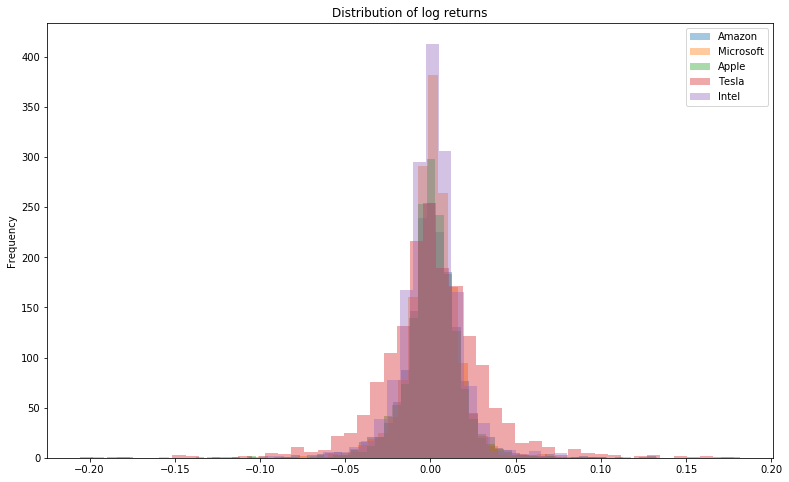

In [207]:
portfolio.plot_volatility_of_each_stock(df)

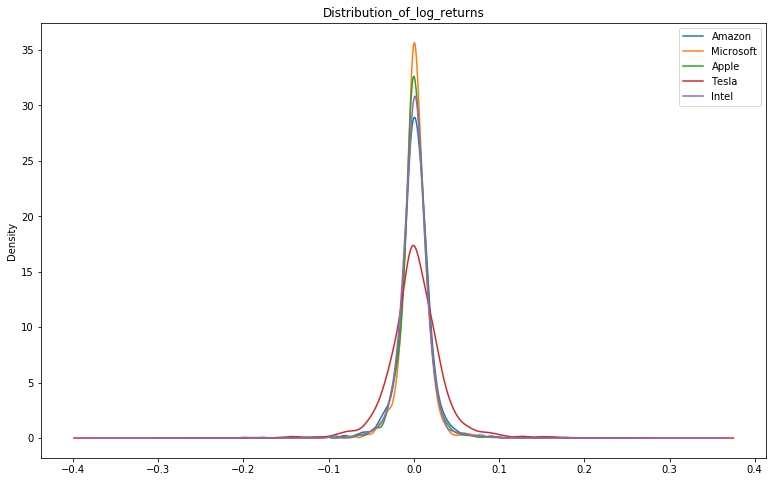

In [208]:
portfolio.plot_return_distribution_each_stock(df)

The Sharp Ratio of the Sharp Portfolio is 1.211
The Sharp Ratio of the Minimum Variance is 1.078


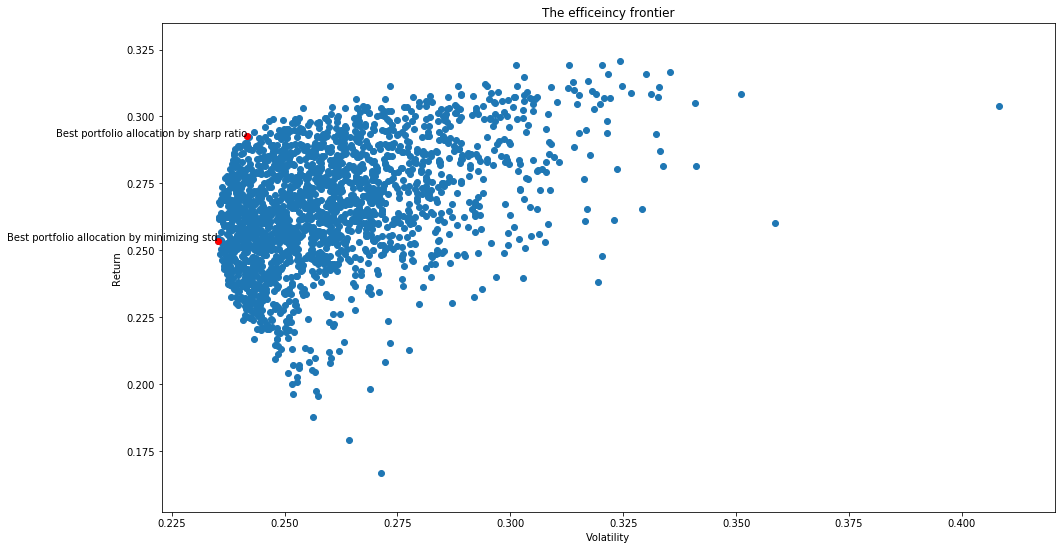

In [209]:
portfolio.effective_frontier(df)

,Sharp,Minimum Variance
Weights,,
Amazon,0.295950,0.225617
Microsoft,0.345434,0.285768
Apple,0.259514,0.277964
Tesla,0.087054,0.003042
Intel,0.012049,0.207609


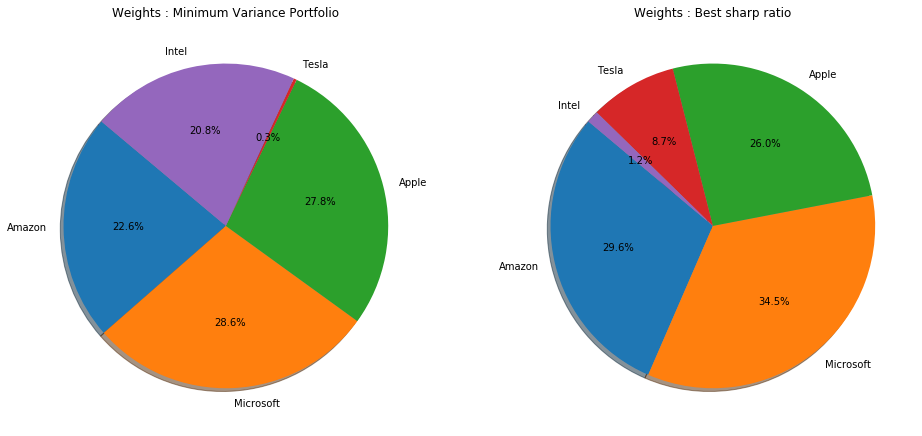

In [210]:
portfolio.plot_weights_of_optimal(names)

The return of sharp portfolio is : 0.293 and for the minimum variance portfolio is : 0.254
The Std of sharp portfolio is : 0.242 and for the minimum variance portfolio is : 0.235


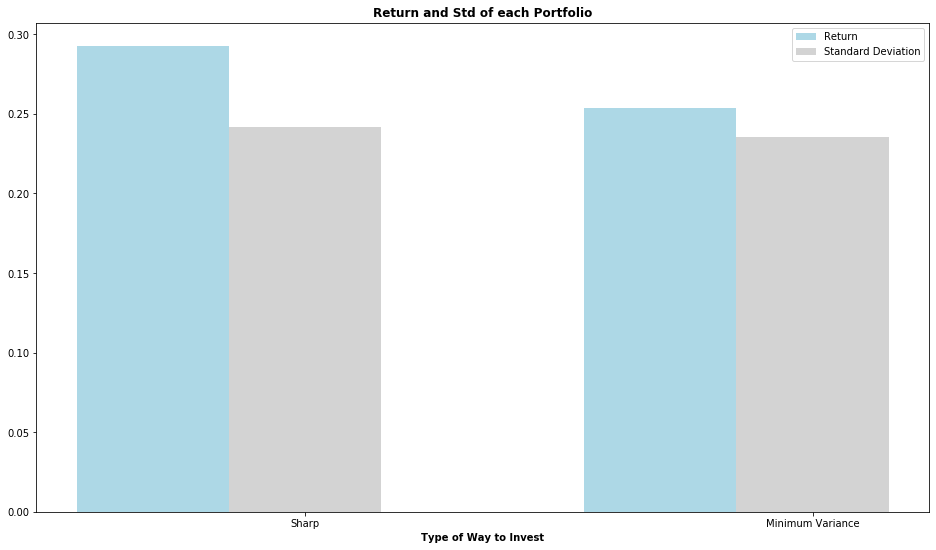

In [211]:
portfolio.compare_annual_returns(df)

{'Beta': 0.739, 'Alpha': -0.0, 'R-Squared': 0.906, 'P_Value': 0.0, 'Standard deviation': 0.008}


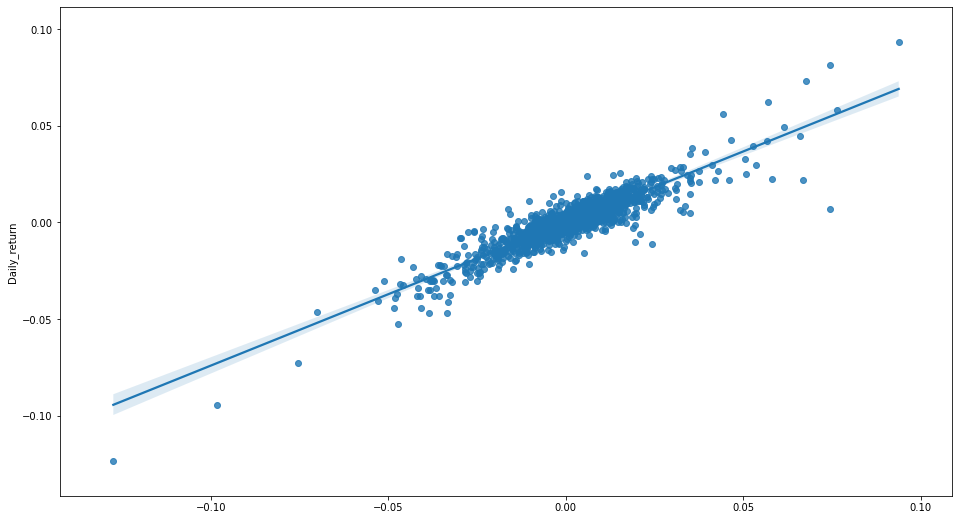

In [212]:
portfolio.relation_portfolio_to_market(df,portfolio.sharp_weights)

{'Beta': 0.772, 'Alpha': -0.0, 'R-Squared': 0.921, 'P_Value': 0.0, 'Standard deviation': 0.008}


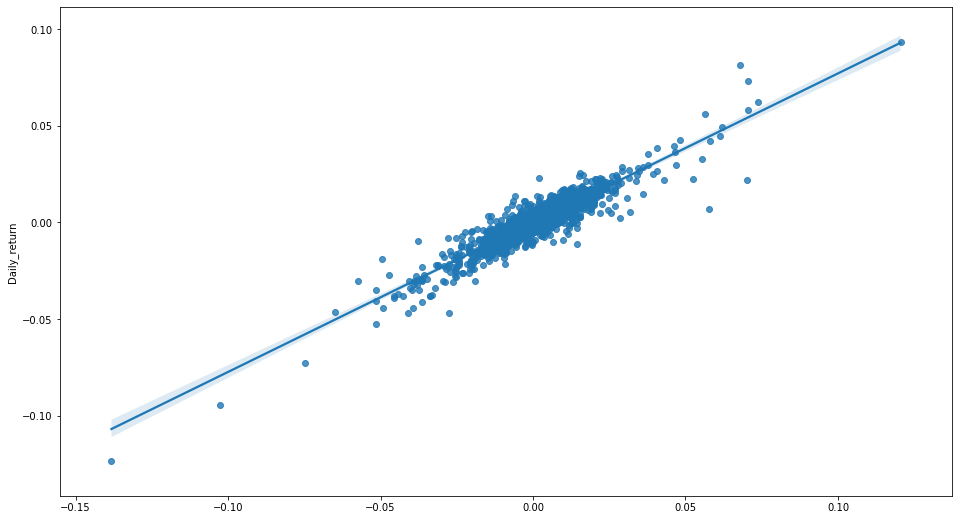

In [213]:
portfolio.relation_portfolio_to_market(df,portfolio.minimum_weights)

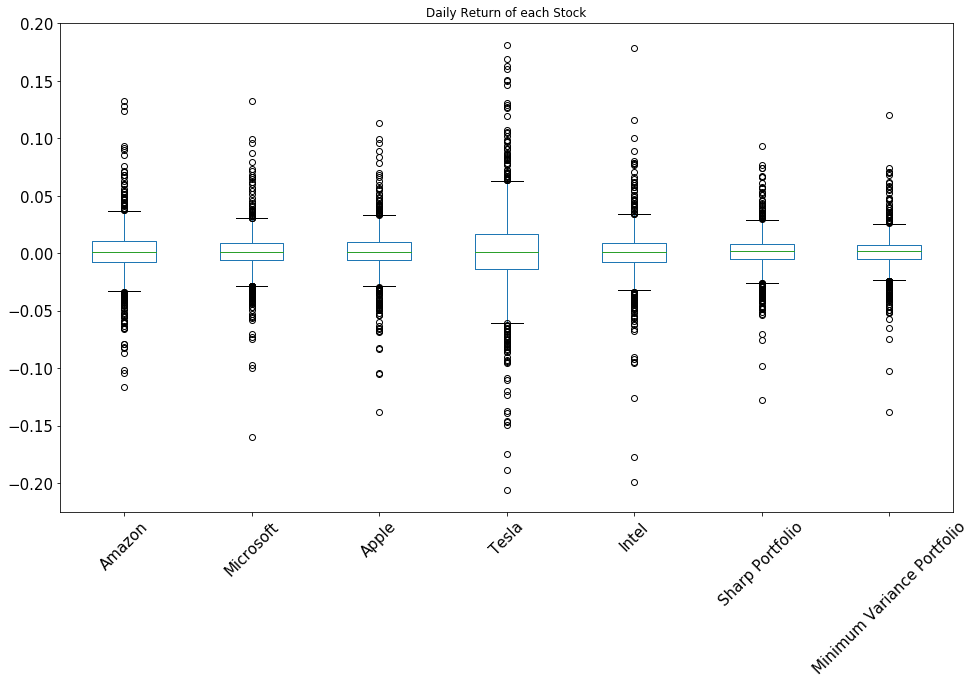

In [214]:
portfolio.box_plot_return_ingredients_portfolio(df)

The total position value of the sharpe portfolio is 1656    348100.800956
Name: Total Positions Value, dtype: float64
The total position value of the Minimum Variance portfolio is 1656    288391.917758
Name: Total Positions Value, dtype: float64


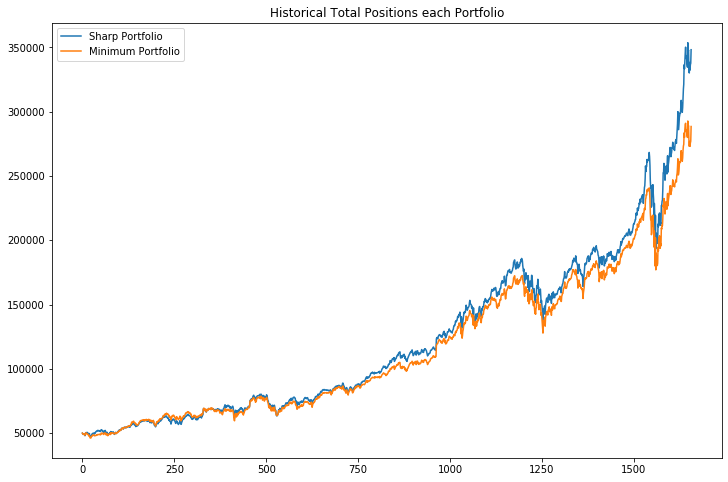

In [215]:
portfolio.plot_total_positions_value(df)